In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random, shutil
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import InceptionV3, VGG16
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.callbacks import EarlyStopping
from pathlib import Path
import cv2
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
#dir_path = 'C:/Users/srija/Downloads/chest_xray'
dir_path = "/home/sysadm/Documents/chest_xray/"
train_dir = dir_path + '/train'
test_dir = dir_path + '/test'

In [3]:
classes = []
for i in os.listdir(train_dir):
  classes.append(i)
classes

['NORMAL', 'PNEUMONIA']

In [4]:
n_train = []
n_test = []
for c in classes:
  train_images = os.listdir(train_dir + '/' + c)
  n_train.append(len(train_images))
  test_images = os.listdir(test_dir + '/' + c)
  n_test.append(len(test_images))

In [5]:
print(n_train)
print(n_test)

[1341, 3875]
[234, 390]


In [6]:
data = pd.DataFrame({'Classes' : classes,
                      'Train' : n_train,
                      'Test' : n_test})
print(data)

     Classes  Train  Test
0     NORMAL   1341   234
1  PNEUMONIA   3875   390


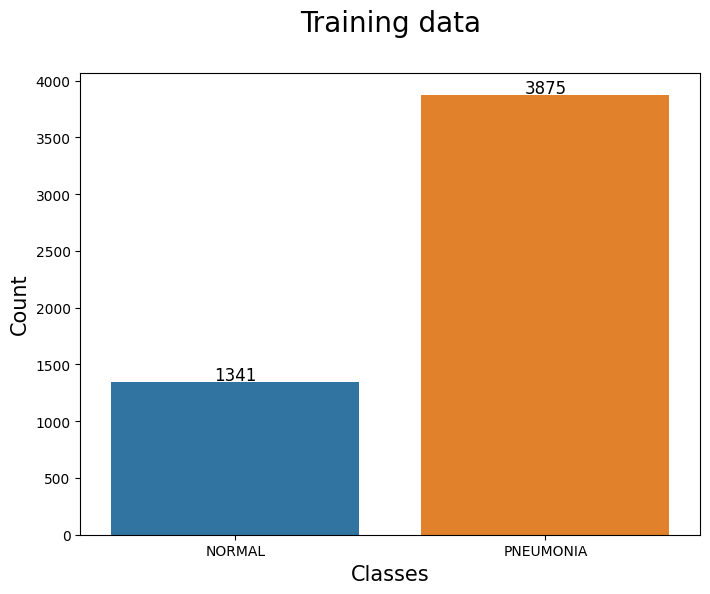

In [7]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data=data, x='Classes', y='Train')
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Training data', fontsize=20, pad=30)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

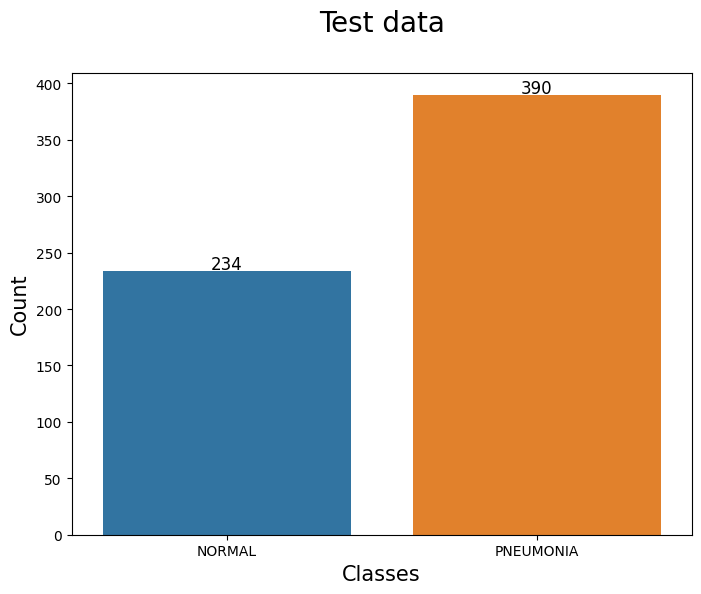

In [8]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data=data, x='Classes', y='Test')
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Test data', fontsize=20, pad=30)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

In [9]:
train_directory = os.path.join(dir_path, 'train')
validation_directory = os.path.join(dir_path, 'validation')

validation_split = 0.2

os.makedirs(validation_directory, exist_ok=True)

In [10]:
for class_name in ['NORMAL', 'PNEUMONIA']:
    class_directory = os.path.join(train_directory, class_name)
    validation_class_directory = os.path.join(validation_directory, class_name)

    os.makedirs(validation_class_directory, exist_ok=True)

    images = os.listdir(class_directory)

    num_validation_images = int(len(images) * validation_split)

    validation_images = random.sample(images, num_validation_images)

    for image in validation_images:
        source_path = os.path.join(class_directory, image)
        destination_path = os.path.join(validation_class_directory, image)
        shutil.move(source_path, destination_path)

print('Validation set created successfully.')

Validation set created successfully.


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,      
    rotation_range=5,     
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,  
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)  

test_datagen = ImageDataGenerator(rescale=1.0/255.0)       

In [12]:
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    os.path.join(dir_path, 'train'),
    target_size=(150, 150),  
    batch_size=batch_size,
    class_mode='binary'      
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(dir_path, 'validation'),
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'      
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dir_path, 'test'),
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'      
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


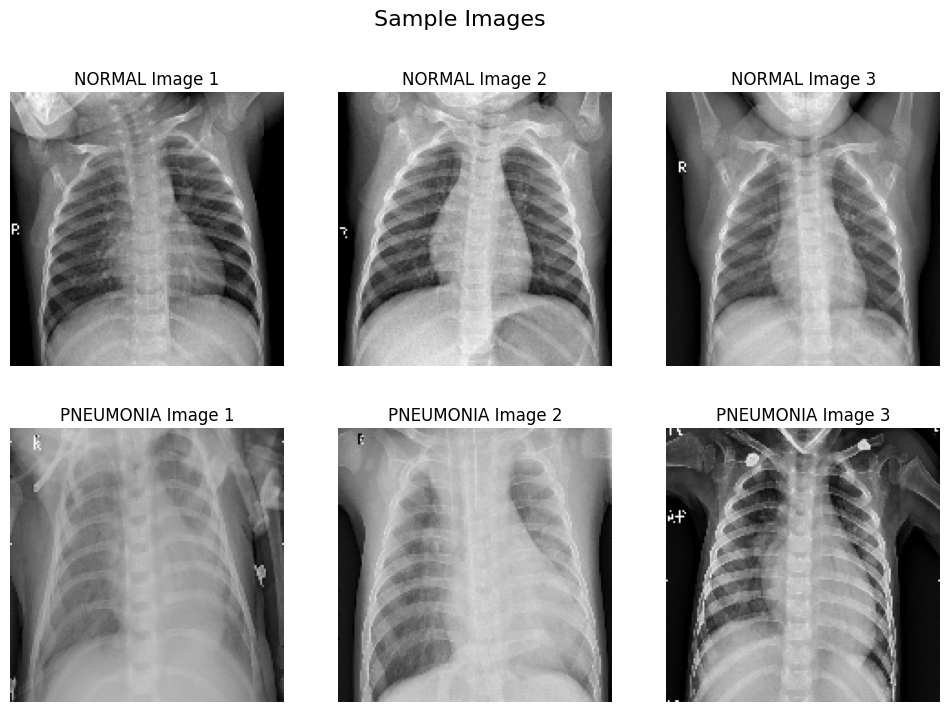

In [70]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Sample Images', fontsize=16)

# Plot three random images from each class
for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_directory, class_name)
    image_files = os.listdir(class_dir)
    random.shuffle(image_files)

    for j in range(3):
        img_path = os.path.join(class_dir, image_files[j])
        img = load_img(img_path, target_size=(150, 150))
        img = img_to_array(img)
        img = train_datagen.standardize(img)

        axes[i, j].imshow(img)
        axes[i, j].set_title(f'{class_name} Image {j+1}')
        axes[i, j].axis('off')

plt.show()

In [71]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [88]:
tf.keras.backend.clear_session()

# Create CNN Model from scratch

In [89]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(150, 150, 3), padding='same'))
model.add(Conv2D(32,(3,3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(32,(3,3), padding='same'))
model.add(Conv2D(32,(3,3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3), padding='same'))
model.add(Conv2D(64,(3,3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation("sigmoid"))

In [90]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 75, 75, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        9

In [91]:
model.compile(loss= "binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [92]:
history = model.fit_generator(train_generator, epochs=100 ,validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/100
131/131 [==============================] - 157s 1s/step - loss: 0.3490 - accuracy: 0.8737 - val_loss: 3.7440 - val_accuracy: 0.7430
Epoch 2/100
131/131 [==============================] - 153s 1s/step - loss: 0.2293 - accuracy: 0.9142 - val_loss: 3.5379 - val_accuracy: 0.7430
Epoch 3/100
131/131 [==============================] - 152s 1s/step - loss: 0.2358 - accuracy: 0.9121 - val_loss: 0.1913 - val_accuracy: 0.9396
Epoch 4/100
131/131 [==============================] - 152s 1s/step - loss: 0.1792 - accuracy: 0.9300 - val_loss: 0.1178 - val_accuracy: 0.9501
Epoch 5/100
131/131 [==============================] - 152s 1s/step - loss: 0.1590 - accuracy: 0.9382 - val_loss: 0.1068 - val_accuracy: 0.9588
Epoch 6/100
131/131 [==============================] - 152s 1s/step - loss: 0.1464 - accuracy: 0.9456 - val_loss: 0.1591 - val_accuracy: 0.9444
Epoch 7/100
131/131 [==============================] - 152s 1s/step - loss: 0.1542 - accuracy: 0.9456 - val_loss: 0.2799 - val_accuracy:

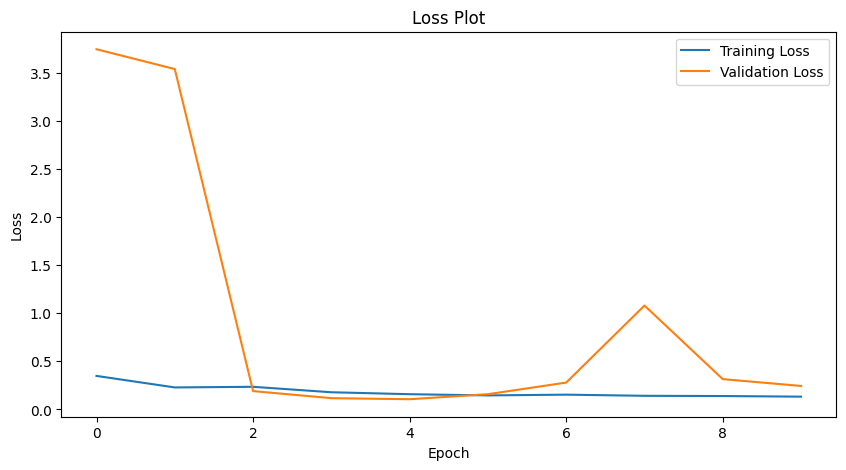

In [93]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

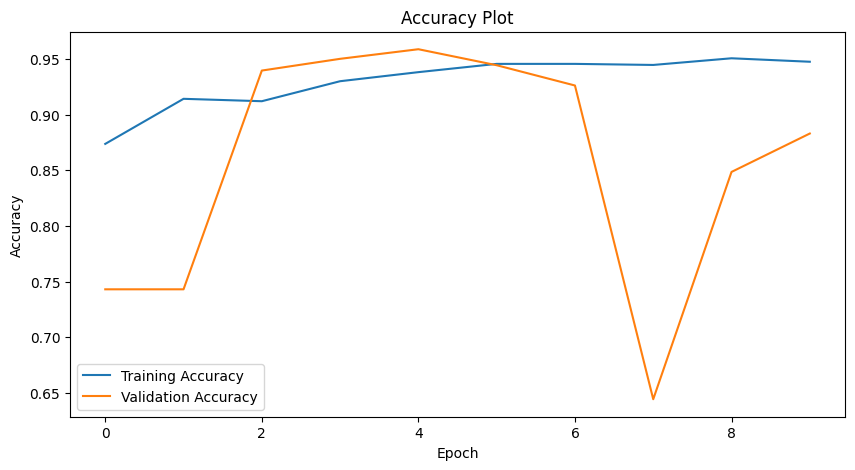

In [94]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

In [95]:
test_accuracy = model.evaluate_generator(test_generator)

In [96]:
print('The accuracy on test set :',test_accuracy[1]*100 )

The accuracy on test set : 72.11538553237915


In [97]:
test_predictions = model.predict(test_generator)
test_predictions = (test_predictions > 0.5).astype(int)
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions))

20/20 [==============================] - 4s 190ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.08      0.12       234
           1       0.61      0.88      0.72       390

    accuracy                           0.58       624
   macro avg       0.45      0.48      0.42       624
weighted avg       0.49      0.58      0.50       624



In [100]:
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 18 216]
 [ 46 344]]


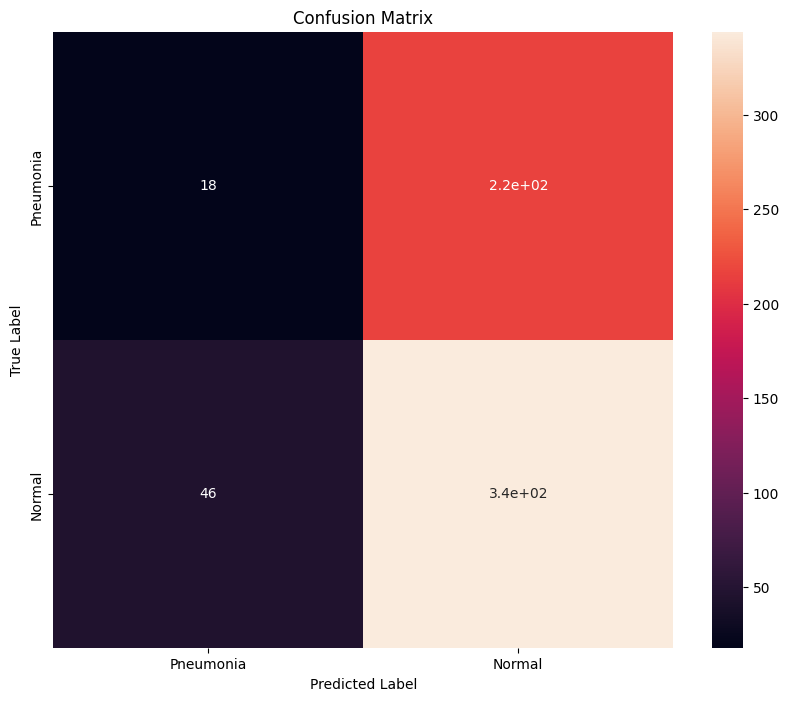

In [101]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, xticklabels=['Pneumonia','Normal'], yticklabels=['Pneumonia','Normal'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [102]:
tf.keras.backend.clear_session()

# Transfer Learning using Inception V3

In [103]:
base_model = InceptionV3(input_shape = (150, 150, 3), weights='imagenet', include_top=False)

In [104]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [105]:
for layer in base_model.layers:
    layer.trainable = True

In [106]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [107]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [108]:
history = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/100
131/131 [==============================] - 245s 2s/step - loss: 0.2078 - accuracy: 0.9298 - val_loss: 8.9071 - val_accuracy: 0.3634
Epoch 2/100
131/131 [==============================] - 234s 2s/step - loss: 0.1596 - accuracy: 0.9463 - val_loss: 4.9171 - val_accuracy: 0.6587
Epoch 3/100
131/131 [==============================] - 233s 2s/step - loss: 0.1314 - accuracy: 0.9545 - val_loss: 0.2562 - val_accuracy: 0.9434
Epoch 4/100
131/131 [==============================] - 234s 2s/step - loss: 0.1651 - accuracy: 0.9418 - val_loss: 0.6384 - val_accuracy: 0.6328
Epoch 5/100
131/131 [==============================] - 234s 2s/step - loss: 0.1745 - accuracy: 0.9399 - val_loss: 0.7468 - val_accuracy: 0.8102
Epoch 6/100
131/131 [==============================] - 234s 2s/step - loss: 0.1073 - accuracy: 0.9617 - val_loss: 0.2544 - val_accuracy: 0.9089
Epoch 7/100
131/131 [==============================] - 234s 2s/step - loss: 0.0939 - accuracy: 0.9641 - val_loss: 0.1542 - val_accuracy:

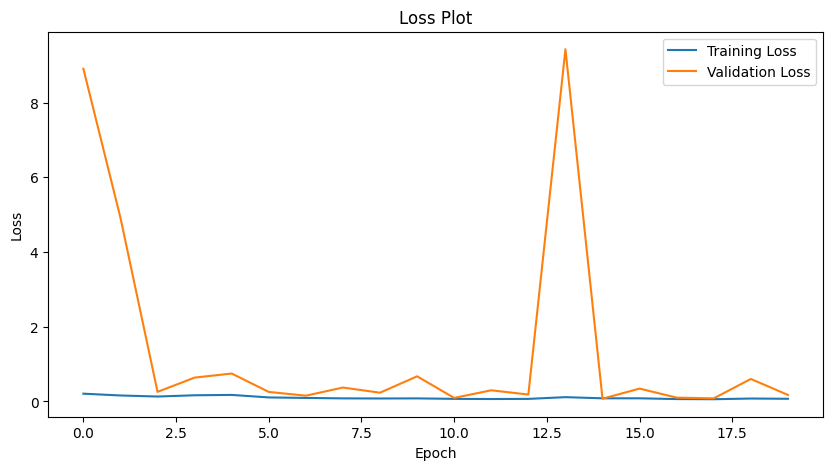

In [109]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

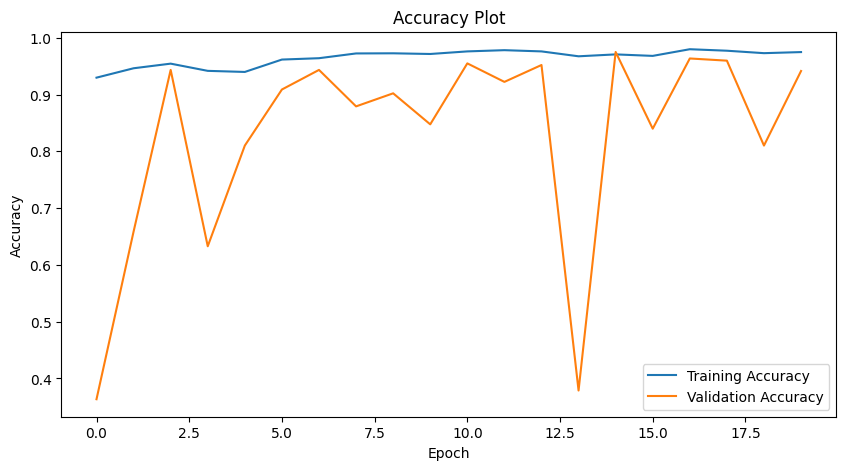

In [110]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

In [111]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

20/20 [==============================] - 5s 256ms/step - loss: 0.5006 - accuracy: 0.8494
Test Loss: 0.5006490349769592, Test Accuracy: 0.8493589758872986


In [112]:
test_predictions = model.predict(test_generator)
test_predictions = (test_predictions > 0.5).astype(int)
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions))

20/20 [==============================] - 6s 256ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.26      0.31       234
           1       0.63      0.77      0.70       390

    accuracy                           0.58       624
   macro avg       0.52      0.52      0.51       624
weighted avg       0.55      0.58      0.55       624



In [113]:
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 60 174]
 [ 88 302]]


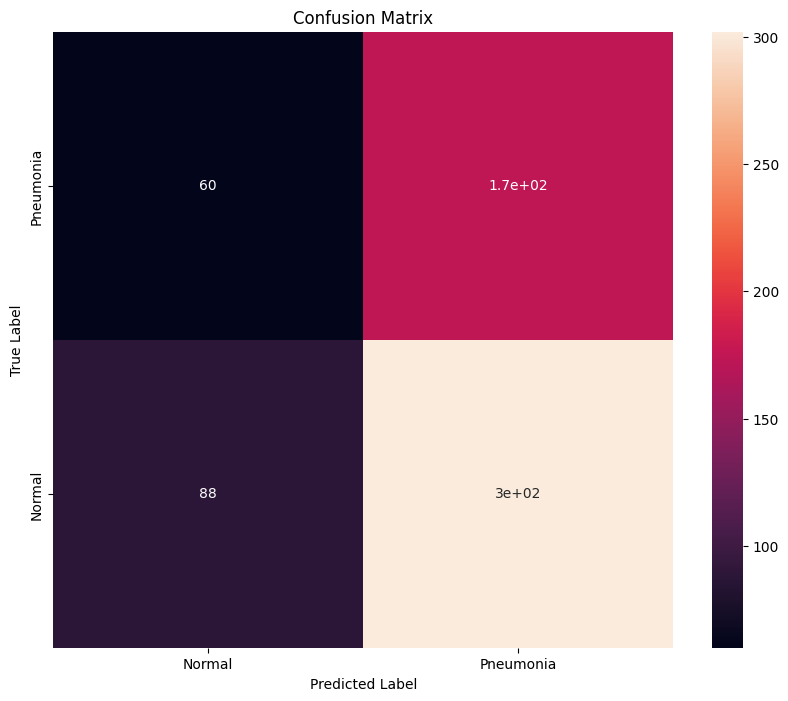

In [114]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, xticklabels=['Normal', 'Pneumonia'], yticklabels=['Pneumonia','Normal'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Saving the trained model
model.save('classifier_model.h5')